# ML Model Development

Here is a comprehensive example of prior process in MLOps. However, in real-world this is most likely an iterative process and it requires more (painstaking) efforts to make the ML model into production.

## Setup

First step in every ML model development is to gather the data. In this example we will use green taxi trip records on in Jan 2021 from [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Note that you can directly download the data using `pd.read_parquet` via passing the data source link.

In [ ]:
!wget -O data/green_tripdata_2021-01.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
!wget -O data/green_tripdata_2021-02.parquet https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet

--2024-05-15 10:07:14--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.161.3.209, 18.161.3.141, 18.161.3.58, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.161.3.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1333519 (1.3M) [binary/octet-stream]
Saving to: ‘data/green_tripdata_2021-01.parquet’

data/green_tripdata 100%[===================>]   1.27M  1.51MB/s    in 0.8s    

2024-05-15 10:07:16 (1.51 MB/s) - ‘data/green_tripdata_2021-01.parquet’ saved [1333519/1333519]

--2024-05-15 10:07:16--  https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 18.161.3.119, 18.161.3.209, 18.161.3.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|18.161.3.119|:443... connected.
HTTP request se

Next, we need to import necessary libraries. You will see the standard packages for data science project here:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

## Data Preprocessing

In any ML project, the most important thing that has a huge impact on your success is data. Therefore, you should make sure that data preprocessing (data cleaning or data preparation) will be done properly. In general, we need to take is explore the data as a whole first such as NaNs and data type checking. Then, we take a look at each intresting features one-by-one. 

Note that **Exploratory Data Analysis (EDA)** should be done along the way as you develop your understand with the data. For this example, we try it out in the code or have a look at [Green Trips Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf).

Remember! keep asking question to yourself: How X will be used to categorize/predict y?

In [2]:
def preprocessing(raw_df):
    """
    Preprocessing data before model training.
    - Create target.
    - Filter only a trip happened within an hour at most.
    """
    df = raw_df.copy()

    df["trip_duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"]).apply(lambda x: x.total_seconds() / 60)
    df = df[(df["trip_duration"] >= 1) & (df["trip_duration"] <= 60)].copy()

    return df

In [3]:
raw_train_df = pd.read_parquet("data/green_tripdata_2021-01.parquet")

In [4]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

Data types seem to be correct though those on some columns like `VENDORID` should be `str`. The reason why data types are mostly correct is that `.parquet` file can store not only the values itself but also its data types. Additionally, some columns have a high volume of NaNs. we can neglect the issue for now as we will use only a few and straigtforward features to create a baseline model.

`preprocessing` function acts like a pipeline for data preparation. In practice, you need to lots of experiment to see which cleaning steps are relevant and necessary for your model.

In [5]:
train_df = preprocessing(raw_train_df)

After you get the `train_df`, let's quickly see the distribution of our target.

In [6]:
train_df["trip_duration"].describe(percentiles=[0.95, 0.98, 0.99])

count    73908.000000
mean        16.852578
std         11.563163
min          1.000000
50%         14.000000
95%         41.000000
98%         48.781000
99%         53.000000
max         60.000000
Name: trip_duration, dtype: float64

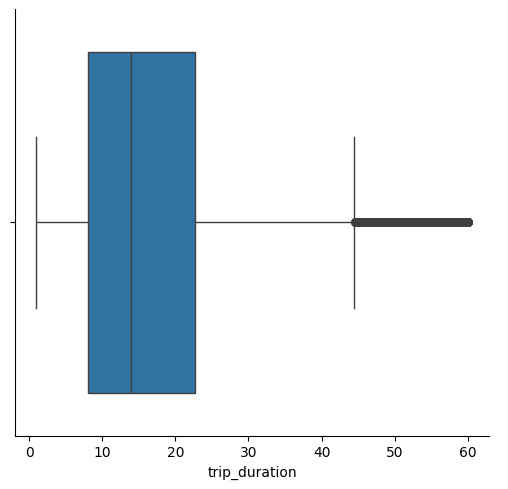

In [7]:
sns.catplot(data=train_df, x="trip_duration", kind="box")
plt.show()

Little bit long tail to the right! This means you need to apply feature engineering to make `trip_duration` distribute normally. Otherwise, we can get skewed results towards those outliers.

## Feature Engineering

In the real-world, feature engineering is very complex and sometimes it requires various advanced techniques and steps such as feature selection. For this purpose of getting baseline ML model, we will build up a model based on three distinct features that intuitively represent `trip_duration`. Those are `PULocationID`, `DOLocationID` and `trip_distance`.

In [8]:
from sklearn.feature_extraction import DictVectorizer

In [9]:
def feature_engineering(df, categorical_features, numerical_features, target, v=None):
    """
    Feature engineering.
    - One-hot encoding
    - Generate X and y
    """
    data = df[categorical_features + numerical_features].to_dict(orient="records")

    if v is None:
        v = DictVectorizer()
        X = v.fit_transform(data)
    else:
        X = v.transform(data)
    
    y = df[target].values

    return v, X, y

In [10]:
categorical_features = ["PULocationID", "DOLocationID"]
numerical_features = ["trip_distance"]

target = "trip_duration"

Note that in practice you may not separate features into categorical and numerical type like this at the first trial. Instead, you are likely to do experiment with data analysis and feature selection techniques or even a couple of model training to get to know which features to use and how to transform your base features into the ready-to-train features. However, at the end, you may finish with these setup as in my opionion this is the most convenient for creating a ML pipeline.

Moreover, as you can see the values of `PULocationID` and `DOLocationID` are `int` but it show characteristic of categorical types of data with a high cardinality. As a result, we need to transform those features in a way that they still represent the context of the data. This process is call feature encoding.

Luckily, in *scikit-learn*, it has a convenient function called `DictVectorizer`, which is not only encode our categorical features (using one-hot encoding) but also convert other features into 2D-array ready to be fed into a model. One thing to note here is that `DictVectorizer` can automatically encode categorical features as long as they are of type string. Therefore, you may need to do type casting first before transforming it into a 2D-array data.

We also need to build `y_train` to be our target data. In most cases, `y_train` need to be in 1D-array.

In [11]:
train_df[categorical_features] = train_df[categorical_features].astype(str)
v, X_train, y_train = feature_engineering(train_df, categorical_features, numerical_features, target)

In [12]:
print(f"Feature vector: {X_train.shape}")
print(f"Output vector: {y_train.shape}")

Feature vector: (73908, 507)
Output vector: (73908,)


Now you ready to train a ML model! In general, there are a few things that you need to do in the data preparation (sometimes includes feature engineering) process before you can train a model. Here are the following:

* Clean up missing values (NaNs)
* Encode categorical features

Both are the important ones to get you started with the training process. However, there are a few things that you can quickly do as well and it may boost up your model performance. Here are recommended steps:

* Change data types - This helps you as a model developer to gain more understanding in the meaning of your data
* Remove duplicate samples
* Feature scaling for numerical features (and targets)
* Basic feature engineering - feature crosses and datetime features (time-series forecasting)

Let's keep these things in mind but we will drop these for now and jump right into training the model!

## Model Building

### Model Training

We will start with a simple linear regression for predicting numerical values.

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

### Model Validation

In order to know whether our ML model is a good one, we need a way to measure the performance of it. Mostly, it is done empirically as it is the nature of the field anyway (experimentation)! Therefore, we need a two things on this process - validation dataset (representation of unseen data)and metrics.

Let's start with the validation dataset. If you recall, in this example, we are going through the data preprocessing and feature engineering to get `X_train` and `y_train`. These processes also need to be done step-by-step on the validation dataset as well.

In this example, we will use green taxi trip records in Feb 2021 as validation dataset.

In [15]:
raw_validation_df = pd.read_parquet("data/green_tripdata_2021-02.parquet")

A note here is that in practice you will not get a separate set of data like this. If that happens and you get only a big set (or a small set), you will need to create at least two set of it yourself. This is called data splitting.

Data splitting is a tricky process and you are likely to introduce bias to your ML development. The trick is to create large enough sample size with the same distribution as training dataset on validation dataset and if you dataset is small, cross validation is your friend!

Although, data exploration might not necessary anymore as it will be done via other tools to automatically spot distribution shift, I would like to do a quick check on the validation dataset. As a data scientist, it is good to keep asking question about your data!

In [16]:
raw_validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64572 entries, 0 to 64571
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               64572 non-null  int64         
 1   lpep_pickup_datetime   64572 non-null  datetime64[us]
 2   lpep_dropoff_datetime  64572 non-null  datetime64[us]
 3   store_and_fwd_flag     35463 non-null  object        
 4   RatecodeID             35463 non-null  float64       
 5   PULocationID           64572 non-null  int64         
 6   DOLocationID           64572 non-null  int64         
 7   passenger_count        35463 non-null  float64       
 8   trip_distance          64572 non-null  float64       
 9   fare_amount            64572 non-null  float64       
 10  extra                  64572 non-null  float64       
 11  mta_tax                64572 non-null  float64       
 12  tip_amount             64572 non-null  float64       
 13  t

There are few records than the training dataset and seem to have the same NaNs problem.

In [17]:
validation_df = preprocessing(raw_validation_df)

In [18]:
validation_df["trip_duration"].describe(percentiles=[0.95, 0.98, 0.99])

count    61921.000000
mean        17.848622
std         12.172529
min          1.000000
50%         14.666667
95%         43.700000
98%         51.000000
99%         55.000000
max         60.000000
Name: trip_duration, dtype: float64

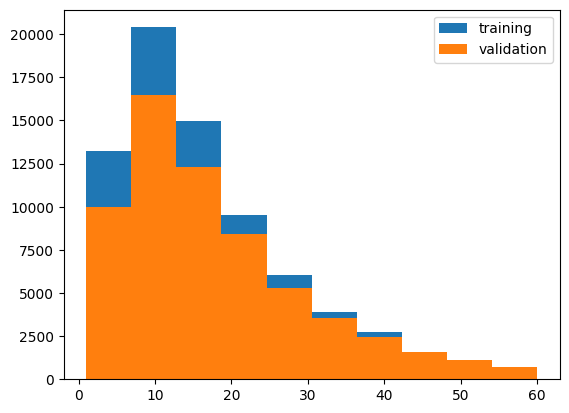

In [19]:
plt.hist(x=train_df["trip_duration"], label="training")
plt.hist(x=validation_df["trip_duration"], label="validation")

plt.legend()
plt.show()

Good! Both training and validation dataset have the same distribution.

One quick note here is that sadly, in practice two dataset is not enough. In model development, you will likely to perform several experiments. For example, doing hyperparameter tuning and validate performance against the prior setup or trying out new features and measure the performance again and again. The point is you can "overfit" to the validation dataset as the model is only modified based on this data. Having another "test set" is consider a good idea because it will do the job as we expect at first - measure the performance over the unseen data.

In [20]:
validation_df[categorical_features] = validation_df[categorical_features].astype(str)
_, X_validation, y_validation = feature_engineering(validation_df, categorical_features, numerical_features, target, v=v)

In [21]:
print(f"Feature vector: {X_validation.shape}")
print(f"Output vector: {y_validation.shape}")

Feature vector: (61921, 507)
Output vector: (61921,)


Note that *scikit-learn* has a utility function to create a sophiticated pipeline and make data preprocessing and feature engineering process as a part of model which you can save as an artifact. This promotes reproducibility and helps your code cleaner.

Now that we completed validation dataset preparation, we can use `predict` method to create prediction values for this dataset. 

In [22]:
y_pred = reg.predict(X_validation)

#### Error Analysis

Next, we focus on metrics. It is a way to quantify our model performance and there are several common metrics for each type of tasks. In this example, it is a regression type of problems so we may choose **Root Mean Squared Error (RMSE)**.

In [23]:
from sklearn.metrics import root_mean_squared_error

In [24]:
rmse = root_mean_squared_error(y_validation, y_pred)
print(f"RMSE on validation dataset: {rmse:.2f}")

RMSE on validation dataset: 10.50


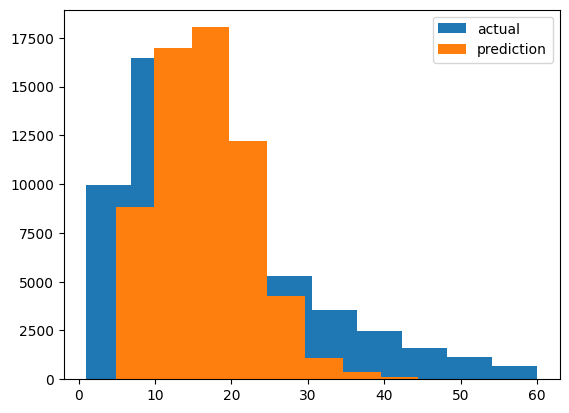

In [25]:
plt.hist(x=y_validation, label="actual")
plt.hist(x=y_pred, label="prediction")

plt.legend()
plt.show()

As you can see, the prediction and error look nice but we can do better! Error analysis is the process that we perform after every validation to make a thorough analysis on the prediction compared to the actual values.

Let's start with **RMSE**. The way to check if it is a good model based on the metric is up to the business problem. In this example, it looks ok but you can imagine that you are on the way to the airport to take a flight which about to leave in 30 minutes. The model predicts that you will arrive in 20 minutes but its underlying is that it can vary about 10 minutes, which has an effect on the reliability of the usage. It then leads to a significant impact on the user.

In details, for the distribution, the shape is very similar which is a good starting point. However, it tends to shift toward the higher valules. This may be from the right-tail distribution of the target itself. The possible next step may be to deal with scaling in order to remove these skewed results or may be doing more advanced feature engineering to boost the performance.

#### Feature Crosses

Feature crosses is a synthetic feature that use cross product to create the combination of categories to which can be assigned weights instead of the ones relying on the raw categorical themselves. This technique helps increase non-linearity to the model but one thing to bear in mind is that the more features or high cardinality you use to create feature crosses, the more spare the feature vectors can be. The spare vectors often lead to overfitting behavior of the model.

In this example, instead of using both `PULocationID` and `DOLocationID`, we will use cross product of those two features. This represents the a single-round trip from a to b, which not only captures the relationship between the features but also provide a more complex weight assignment to the model.

Let's try it out in action to see if it consider more useful than just a single `PULocationID` or `DOLocationID`. 

In [26]:
def build_features(df):
    """
    Build synthetic features.
    - RouteID: PULocationID x DOLocationID
    """
    feature_df = df.copy()
    feature_df["RouteID"] = feature_df["PULocationID"] + '_' + feature_df["DOLocationID"]

    return feature_df

In [27]:
train_df = build_features(train_df)
validation_df = build_features(validation_df)

Then, we are going to go to the whole process of model development again (after what we came back to is feature engineering/feature selection).

In [28]:
categorical_features = ["RouteID"]
numerical_features = ["trip_distance"]

target = "trip_duration"

In [29]:
v, X_train, y_train = feature_engineering(train_df, categorical_features, numerical_features, target)
print(f"Feature vector: {X_train.shape}")
print(f"Output vector: {y_train.shape}")

reg = LinearRegression()
reg.fit(X_train, y_train)

Feature vector: (73908, 13221)
Output vector: (73908,)


LinearRegression()

In [30]:
_, X_validation, y_validation = feature_engineering(validation_df, categorical_features, numerical_features, target, v=v)
print(f"Feature vector: {X_validation.shape}")
print(f"Output vector: {y_validation.shape}")

y_pred = reg.predict(X_validation)

Feature vector: (61921, 13221)
Output vector: (61921,)


RMSE on validation dataset: 7.76


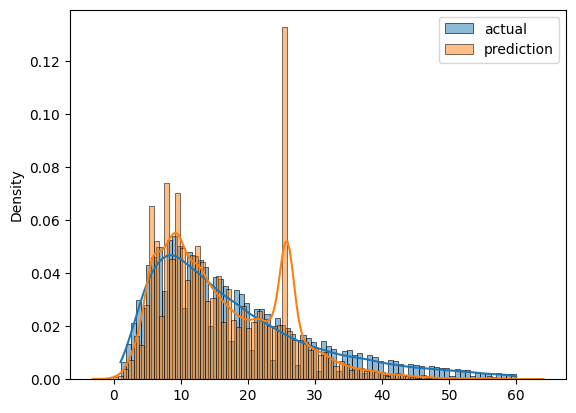

In [31]:
rmse = root_mean_squared_error(y_validation, y_pred)
print(f"RMSE on validation dataset: {rmse:.2f}")

sns.histplot(y_validation, label="actual", kde=True, stat="density")
sns.histplot(y_pred, label="prediction", kde=True, stat="density")

plt.legend()
plt.show()

Nice! You can lower the error around 30% using feature crosses. Also, the distribution seems to be better except for the prediction around 25 minutes. However, you can take a look on those samples later on in your ML development journey. Currently, I think this is enough for baseline model.

#### (Optional) Model Selection

In practice, it is not necessary the cast that your baseline model is a linear regression. To show capabilities of other models, I would like to see what if we add regularization to our model: Will it perform better?

We will use **Elastic Net**, which combines both L1 and L2 regularization. Although, in this case, I think it is not going to improve anything as from error analysis the model is likely in underfitting situation, it is worth learning to tuning some hyperparameters a bit.

In [32]:
from sklearn.linear_model import ElasticNet

In [33]:
regr = ElasticNet(alpha=0.001, l1_ratio=0.95, random_state=42)
regr.fit(X_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.95, random_state=42)

RMSE on validation dataset: 9.42


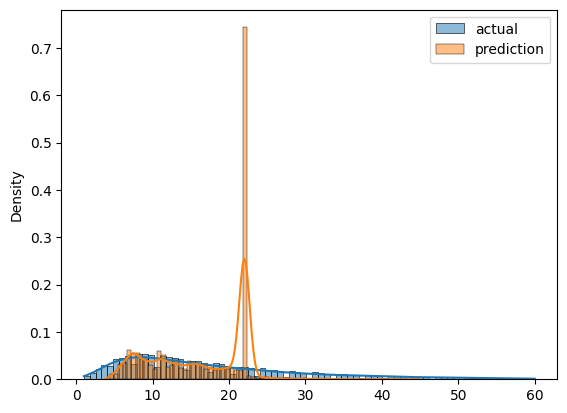

In [34]:
y_pred = regr.predict(X_validation)

rmse = root_mean_squared_error(y_validation, y_pred)
print(f"RMSE on validation dataset: {rmse:.2f}")

sns.histplot(y_validation, label="actual", kde=True, stat="density")
sns.histplot(y_pred, label="prediction", kde=True, stat="density")

plt.legend()
plt.show()

As you can see, it perform worse than the linear regression model due to the outlier prediction around 25 minutes. The reason is that regularization helps the model try not to make too much fit on the data which as a whole it turns out not fit the outlier less (may be it is a good thing but from RMSE only is not suffice to say that we make an improvement).

### Model Persistence

Now that we have a baseline model, we need to keep track of it. One easy way is to save it and name it as `linear-baseline.pkl`. Note that you will see other methods to do model versioning later on in the course.

Another thing is that along the way you can see we have different versions and purposes of dataset such as training set or validation set after 1st feature engineering. It is known to the MLOps best practices that we should keep track of data versioning as well. 

In [35]:
import pickle

In [36]:
with open("models/linear-baseline.pkl", "wb") as f:
    pickle.dump((v, reg), f)